In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import seaborn as sns
import thinkstats2
import thinkplot
import survival


# Survival Analysis

Survival analysis is the examination of how long we expect something to last or continue. For example, how long do we expect someone to live after a certain diagnosis, how long we expect a customer to remain a customer, or how long we expect someone to remain at a job. 

![Survive](images/survive.gif "Survive")

Survival analysis is another way we can use our distribution data to make projections, or inferences, about the future. To do our survival analysis we need two key pieces of information:
<ul>
<li> A measure of time - how long they have lasted. 
<li> An indication of the "event" - whenever the survival thing happens. E.g. death, a customer leaves, a lightbulb fails. 
</ul>

If we have a dataset that shows us how long until an event happens for the records in our sample, we can create a distribution from that data to estimate the time to event, and we can do some manipulations of that data to create some survival specific tools and techniques. A

### Type of Analysis

We will do some univariate survival analysis, or we will use one variable - the time somemthing lasts. The event varaible is more of an indication that the time something lasts is now over, it isn't really it's own feature. It is possible, though a bit more complex, to do survival analysis with a larger feature set, just like regression/classification. The lifelines package referenced near the bottom of the workbook provides some tools for this, we <i>may</i> get into it during the ML stuff, largely dependent on what we need to cover for your project work. 

##### Example Data

Below, we'll load some data on turnonver. The stag column indicates how long, in months, someone has been employed; the event column indicates if they have left a company. 

In [2]:
df = pd.read_csv("data/turnover.csv",encoding = "ISO-8859-1")
df["stag"] = np.round(df["stag"])
df.head()

,stag,event,gender,age,industry,profession,traffic,coach,head_gender,greywage,way,extraversion,independ,selfcontrol,anxiety,novator
0,7.0,1,m,35.0,Banks,HR,rabrecNErab,no,f,white,bus,6.2,4.1,5.7,7.1,8.3
1,23.0,1,m,33.0,Banks,HR,empjs,no,m,white,bus,6.2,4.1,5.7,7.1,8.3
2,16.0,1,f,35.0,PowerGeneration,HR,rabrecNErab,no,m,white,bus,6.2,6.2,2.6,4.8,8.3
3,16.0,1,f,35.0,PowerGeneration,HR,rabrecNErab,no,m,white,bus,5.4,7.6,4.9,2.5,6.7
4,8.0,1,m,32.0,Retail,Commercial,youjs,yes,f,white,bus,3.0,4.1,8.0,7.1,3.7


##### Exercise Data

We can also load some other data that we can work on for some exercises. This data is on how long someone is a customer of a phone company. 

"tenure" is the duration that they've been a customer.
"Churn" is if they've left, or if they're still there. 

In [3]:
d2 = pd.read_csv("data/churn.csv")
d2.head()

,customerID,gender,SeniorCitizen,Partner,Dependents,tenure,PhoneService,MultipleLines,InternetService,OnlineSecurity,...,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,Contract,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,Churn
0,7590-VHVEG,Female,0,Yes,No,1,No,No phone service,DSL,No,...,No,No,No,No,Month-to-month,Yes,Electronic check,29.85,29.85,No
1,5575-GNVDE,Male,0,No,No,34,Yes,No,DSL,Yes,...,Yes,No,No,No,One year,No,Mailed check,56.95,1889.5,No
2,3668-QPYBK,Male,0,No,No,2,Yes,No,DSL,Yes,...,No,No,No,No,Month-to-month,Yes,Mailed check,53.85,108.15,Yes
3,7795-CFOCW,Male,0,No,No,45,No,No phone service,DSL,Yes,...,Yes,Yes,No,No,One year,No,Bank transfer (automatic),42.30,1840.75,No
4,9237-HQITU,Female,0,No,No,2,Yes,No,Fiber optic,No,...,No,No,No,No,Month-to-month,Yes,Electronic check,70.70,151.65,Yes


## Survival and CDF

The idea of survival should remind us of something we're really comfortable with - the CDF. Recall, the CDF shows us an accumulation of what percentage of all records are less than X value; if that X value is time, the CDF shows us how many things last less than X. So our survival analysis is basically examining a distribution of the time varaible. 

Survival is the opposite of that, or more accurately, the complement of the CDF of time. The survival is what percentage has lasted that long. Mathmatically, the survival is simple: 1-cdf(x).

$ S(x) = 1 - CDF(x) $

Visually, we can look at how they interact by graphing the cdf, survival, and both together. 

In [4]:
import survival
def MakeSurvivalFromCdf(cdf, label=''):
    """Makes a survival function based on a CDF.

    cdf: Cdf
    
    returns: SurvivalFunction
    """
    ts = cdf.xs
    ss = 1 - cdf.ps
    return survival.SurvivalFunction(ts, ss, label)

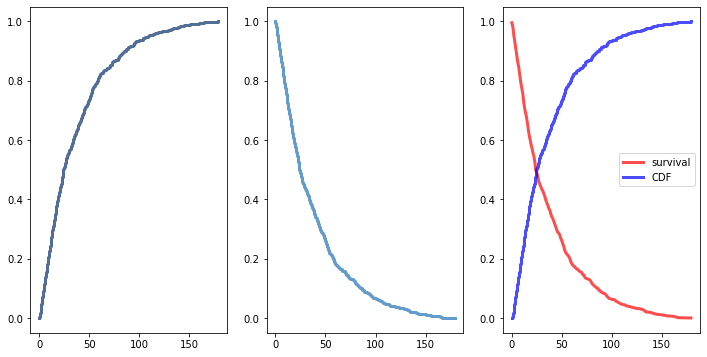

In [5]:
thinkplot.PrePlot(3,1,3)
cdf = thinkstats2.Cdf(df["stag"])
thinkplot.Cdf(cdf)
thinkplot.SubPlot(2)
thinkplot.Cdf(cdf, complement=True)
thinkplot.SubPlot(3)
sf = MakeSurvivalFromCdf(cdf)
thinkplot.Plot(sf, label='survival', color="red")
thinkplot.Cdf(cdf, color="blue", label="CDF")
thinkplot.Config()

#### Survival and CDF Results

The two functions always sum to 1. Analytically we can also see this in the results of the calculations below.

How many employees last less/more than 24 months:

In [6]:
#Above or below 24 months
print(cdf[24])
print(sf[24])

0.5022143489813995
0.4977856510186005


#### Exercise - Print CDF and Survival for the Churn Data

In [7]:
#Calculate above or below 24 months


## Hazard Function - Non-Cumulative Events

The hazard function shows how many things end or "happen" at any given time point of t, of all things that made it that far:

$ H(t) = \frac{(S(t) - S(t+1))}{S(t)} $

Which is just a simple calculation of the probability of an event happening at time t. Just like the PDF shows the value at any given point, and the CDF shows the cumulative total, the hazard function shows the probability of "the event" at any given point, and the survival function shows the cumulative total. The hazard function can also be described as the "instantaneous likelihood of failure" - the probability that it dies at that moment. In SAT speak, if you're a trivia nerd (or you're applying to go to college in the US):

$$ PDF:CDF :: hazard:survival $$

Importantly, the hazard function always gives us results in terms of "of those remaining", so if a hazard function tells us that someone has a 5% chance of dropping dead in the 84th week after receiving a drug, that 5% is 5% of the people still alive at week 84, not 5% of all people involved at the start. For example, the hazard function will show: of all employees that lasted 24 months, how many ended their employment in that month. We can draw a line to make the connection a bit more clear on the chart. Our data has the time interval in months, so the value of each point on the chart is "events in this month". 

Employees that left in 24th month: 0.05387205387205399


e:\OneDrive - NAIT\Data 3450\Basic_Stats_in_Python_Student_Workbooks\survival.py:71: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  lams = pd.Series(index=self.ts)


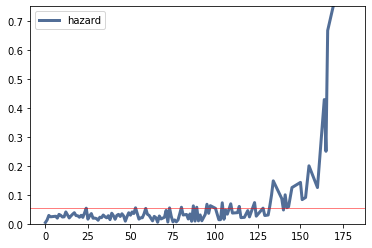

In [8]:
hf = sf.MakeHazardFunction(label='hazard')
print("Employees that left in 24th month:",hf[24])
thinkplot.Plot(hf)
thinkplot.axhline(hf[24], color="red")
thinkplot.Config(ylim=[0, 0.75], loc='upper left')

#### Exercise - Show Hazard Function for Churn

## Estimation: Kaplan-Meier

In real usage, we generally don't have all data in a nice CDF of our population ready to go, in particular we often want to do this analysis before we have a substantial number of "events", or before many of the things have not survived. We can call data such as the still-alive people in a drug trial data that is censored - we don't know the actual true value. We need to make an estimation of the survival and there is a method to do so - Kaplan-Meier Estimation. 

KM is a commonly used function that we can use to estimate a hazard and survival function from some data. The formula (which we don't need to worry about in detail) is:

$ S(t + 1) = S(t) * (1 - d/n) $
<ul>
<li>Where:
    <ul>
    <li> d = number of events at time t.
    <li> n = total number remaining at time t.
    </ul>
</ul>

The survival functions that we end up with are generally a bit blockier than the nice smooth theoretical ones:

![KM](images/km.webp "KM")

### Censorship

One concept that also comes up when looking at survival is the idea of censored data - in short, censored data is data that we don't have "all" of. Specifically in survival analysis, censored data is any data for which we do not know the exact event time. There are three types of censored data; right censored, left censored, and interval cesored. Data for which the exact event time is known is referred to as complete data. In general, our concern with censoring will be right censored data, generally due to items where the event hasn't happened yet. For things like a drug trial, if we are tracking how long patients live, we (hopefully) have a bunch where we don't know the true answer, because they are still alive, we jst know they lived "at least up to this point". In general, this type of data is common for things that use survival analysis - think about a drug trial, if the drug works, we probably don't want to wait 70 years for everyone involved to die before being able to analyze the data and approve the drug. As well, people will commonly do things like stop working with the people conducting the trial, move away to a different city, etc...

![Right Censor](images/right_censor.png "Right Censor")

For us, we will not be doing extensive survival analysis, so it is good enough to be aware of what censored data is, should it become important for something you may be working on. The KM estimation is able to produce estimations that account for the right censored data that we often get in survival analysis. Exactly how to handle censored data beyond this is generally a domain specific thing, depending on exactly what you're analyzing. 

#### Using Kaplan-Meier

To use the Kaplan-Meier process, we supply a list of all the things that have ended, and all those that haven't, and we'll get back a hazard function. We can then make that hazard function into a survival function, so we have the entire picture. 

In [9]:
from collections import Counter

def EstimateHazardFunction(complete, ongoing, label='', verbose=False):
    """Estimates the hazard function by Kaplan-Meier.

    http://en.wikipedia.org/wiki/Kaplan%E2%80%93Meier_estimator

    complete: list of complete lifetimes
    ongoing: list of ongoing lifetimes
    label: string
    verbose: whether to display intermediate results
    """
    if np.sum(np.isnan(complete)):
        raise ValueError("complete contains NaNs")
    if np.sum(np.isnan(ongoing)):
        raise ValueError("ongoing contains NaNs")

    hist_complete = Counter(complete)
    hist_ongoing = Counter(ongoing)

    ts = list(hist_complete | hist_ongoing)
    ts.sort()

    at_risk = len(complete) + len(ongoing)

    lams = pd.Series(index=ts, dtype="float64")
    for t in ts:
        ended = hist_complete[t]
        censored = hist_ongoing[t]

        lams[t] = ended / at_risk
        if verbose:
            print(t, at_risk, ended, censored, lams[t])
        at_risk -= ended + censored

    return survival.HazardFunction(lams, label=label)

Plot the hazard function using the KM estimation:

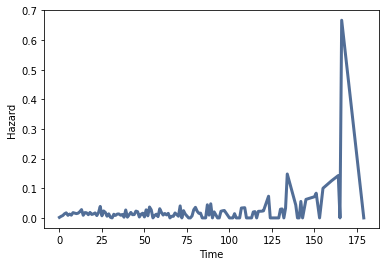

In [10]:
complete = df[df.event==1].stag
ongoing = df[df.event==0].stag

hf = EstimateHazardFunction(complete, ongoing)
thinkplot.Plot(hf)
thinkplot.Config(xlabel='Time',
                 ylabel='Hazard')

From the hazard function, we can then call a function to get the survival function. The idea is pretty simple - we know what fraction will end at any given point, as we have a survival function, so a tally of what is left is pretty conceptually simple. 

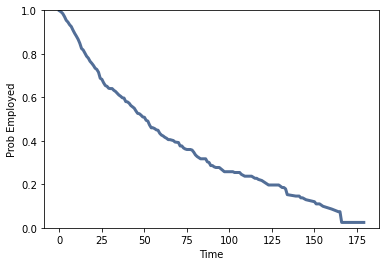

In [11]:
sf = hf.MakeSurvival()
thinkplot.Plot(sf)
thinkplot.Config(xlabel='Time',
                 ylabel='Prob Employed',
                 ylim=[0, 1])

#### Exercise - Generate Hazard and Survival Function with KM for Churn

Hint: May need to look at the values in the Churn column for some data prep. 

### Survival Confidence Intervals

We can use the survival and hazard information to make confidence intervals. The types of error that we are used to also exist in survival. We can use multiple samples to generate confidence just like we did with estimation - the confidence calculations are the same, we run many (e.g. 100) trials of resampling the data, generating a new survival function, and then calculating the range that the middle X% of those iterations. 

In [12]:
def EstimateJobSurvival(resp, columnName="stag", splitName="event"):
    """Estimates the survival curve.

    resp: DataFrame of respondents

    returns: pair of HazardFunction, SurvivalFunction
    """
    # NOTE: Filling missing values would be better than dropping them.
    tmp1 = resp[resp[splitName] == 1]
    tmp2 = resp[resp[splitName] == 0]
    complete = tmp1[columnName]
    ongoing = tmp2[columnName]

    hf = EstimateHazardFunction(complete, ongoing)
    sf = hf.MakeSurvival()

    return hf, sf

In [13]:
def ResampleSurvival(resp, iters=101, columnName="stag", color="blue", ciHi=95, ciLo=5, splitName="event"):
    """Resamples respondents and estimates the survival function.

    resp: DataFrame of respondents
    iters: number of resamples
    """ 
    _, sf = EstimateJobSurvival(resp, columnName, splitName)
    thinkplot.Plot(sf, color=color)

    low, high = resp[columnName].min(), resp[columnName].max()
    ts = np.arange(low, high)

    ss_seq = []
    for _ in range(iters):
        #sample = thinkstats2.ResampleRowsWeighted(resp, column="age")
        sample = thinkstats2.ResampleRows(resp)
        _, sf = EstimateJobSurvival(sample, columnName, splitName)
        ss_seq.append(sf.Probs(ts))

    low, high = thinkstats2.PercentileRows(ss_seq, [ciLo, ciHi])
    thinkplot.FillBetween(ts, low, high, color='gray', label=str(ciHi-ciLo))

#### Show Projection With Confidence Intervals

As we can probably anticipate, the confidence intervals show less and less "confidence" as we progress in time - we are less certain about our projection, the farther out that projection is.

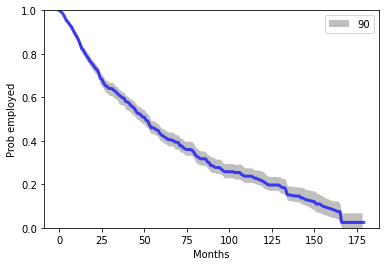

In [14]:
ResampleSurvival(df)
thinkplot.Config(xlabel='Months',
                 ylabel='Prob employed',
                 ylim=[0, 1],
                 loc='upper right')

#### Exercise - Draw Churn with CI of 95%

Hint: Check function arguments above. 

## Survival Comparison - Cohort Differences

One way that survival analysis is useful is to compare groups - most notably in scenarios such as "how long does a treated group live vs a non-treated group?". 

We can split the data in any way we want, such as by sex, then compare those two groups to each other to see if they are different. We can also do a hypothesis test between the two cohorts, just as we are used to. This is normally done using a test that is called the log-rank test, which is in a library called lifelines that provides a bunch of survival analysis stuff. The test itself is internally a Chi2 test. We won't get into the details of lifelines here, but the log-rank test is effectively like a t-test that we did with distributions, it will generate a p-value that we can use to determine if we have evidence to say the cohorts are different from each other. There is an example of this test at the bottom of this workbook using the lifelines package, it is pretty simple to use and understand with our experience with hypothesis tests. 

In [15]:
male = df[df["gender"]=="m"]
fem = df[df["gender"]=="f"]

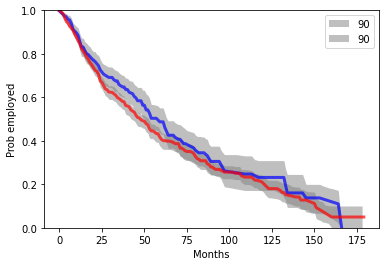

In [16]:
ResampleSurvival(male)
thinkplot.Config(xlabel='Months',
                 ylabel='Prob employed',
                 ylim=[0, 1],
                 loc='upper right')

ResampleSurvival(fem, color="red")
thinkplot.Config(xlabel='Months',
                 ylabel='Prob employed',
                 ylim=[0, 1],
                 loc='upper right',
                 color="red")

Looks like males are a tiny bit more likely to be employed at most points. 

<h4>Exercise - Split Churn Data by InternetService</h4>

## Estimating Remaining Lifetime

We can also estimate how long we can expect someone to "continue" - usually to not die, or continue to be a customer. This calculation is relatively simple, especially for events where we have a definitive cap, such as a pregnancy. If situations where we have right censored data, we can also change the average calculation to median, which will be more durable to outliers - in this case outliers of "infinity". 

We can also kind of describe this in a Bayesian way - our expectation of how long someone will survive is "updated" by our knowledge of how long they have lasted. 

In [17]:
def makePmf(data, filler=None):
    """Makes a PMF of lifetimes.

    filler: value to replace missing values

    returns: Pmf
    """
    cdf = thinkstats2.Cdf(data.ts, 1-data.ss)
    pmf = thinkstats2.Pmf()
    for val, prob in cdf.Items():
        pmf.Set(val, prob)

    cutoff = cdf.ps[-1]
    if filler is not None:
        pmf[filler] = 1-cutoff

    return pmf

def remLifetime(data, filler=None, func=thinkstats2.Pmf.Mean):
    """Computes remaining lifetime as a function of age.
    func: function from conditional Pmf to expected liftime
    returns: Series that maps from age to remaining lifetime
    """
    pmf = makePmf(data,filler=filler)
    d = {}
    for t in sorted(pmf.Values())[:-2]:
        pmf[t] = 0
        pmf.Normalize()
        d[t] = func(pmf) - t

    return pd.Series(d)


#### Estimate Remaining Lifetime at a Point

How long can we expect someone who has worked here for 24 months to continue?

Mean Remaining Emp. at 24 Months: 62.92631643227119


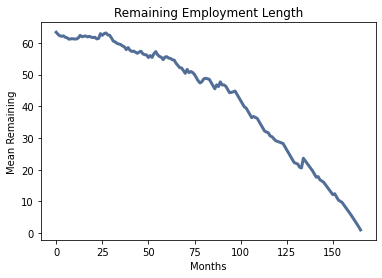

In [18]:
rem_life1 = remLifetime(sf)
print("Mean Remaining Emp. at 24 Months:",rem_life1[24])
thinkplot.Plot(rem_life1)
thinkplot.Config(title='Remaining Employment Length',
                 xlabel='Months',
                 ylabel='Mean Remaining')

We can also specify a function to replace the mean, for example we can ask for the median expected value. This is also an example of something that you may not have seen much before, a function which can take another function as an argument. Some functions are written like this to offer a large amount of flexibility, in this one we can provide any aggregation function (mean, median, mean/2+median/2, some random calculation, etc...) and it will just apply whatever we give it. For a simple interactive look at the idea of how this works, use the "aggregate" function in Excel - the aggregate function does aggregation, and you provide which type you want - sum, average, median, count, etc...

Median Remaining Emp. at 24 Months: 56.0


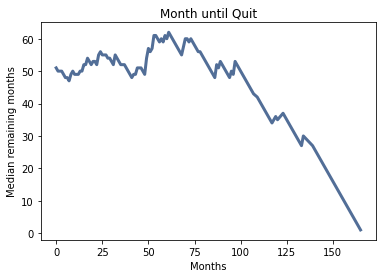

In [19]:
#Provide a generic function via the lambda
#Whatever calculation is here will replace the mean for the remaining life
func = lambda x: x.Percentile(50)
rem_life2 = remLifetime(sf, filler=np.inf, func=func)

print("Median Remaining Emp. at 24 Months:",rem_life2[24])
thinkplot.Plot(rem_life2)
thinkplot.Config(title='Month until Quit',
                 xlabel='Months',
                 ylabel='Median remaining months')

We can also do the exact same thing with a premade median function, this is the thinkstats equivalent to the mean calculation that is used in the original function. 

Median Remaining Emp. at 24 Months: 56.0


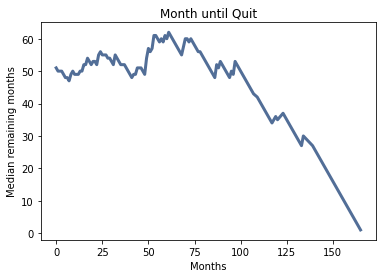

In [20]:
#Provide a generic function via the lambda
#Whatever calculation is here will replace the mean for the remaining life
func2 = thinkstats2.Pmf.Median
rem_life3 = remLifetime(sf, filler=np.inf, func=func2)

print("Median Remaining Emp. at 24 Months:",rem_life3[24])
thinkplot.Plot(rem_life2)
thinkplot.Config(title='Month until Quit',
                 xlabel='Months',
                 ylabel='Median remaining months')

#### Exercise - How Long Should we Expect a Customer of 24 Months to Stay?

## Real Life Survival and Library Functions

We created a bunch of functions here based on the book's stuff to see the details of how survival works. 

In general, we can use library functions for this:
<ul>
<li>The package "lifelines" has most of this stuff in ready to go formats. (You'd likely need to install it)
<li>When using a scipy distribution, there is normally a survival function built in, normally sf.
</ul>

The lifelines library has all of this stuff and more, relating to survival analysis, in a pretty easy to understand and use package. Lifelines also includes a wrapper that allows lifelines functions to be used in a sklearn style way - it basically provides an interface to the lifelines code that matches the sklearn format, so we can incorporate this into our other code without too much adaptation: https://lifelines.readthedocs.io/en/latest/Compatibility%20with%20scikit-learn.html. In the "guides" folder of this repository there is a long document with examples of almost all the common things that we may want to do, the filename is "survival.pdf" and it is taken from: https://pub.towardsai.net/survival-analysis-with-python-tutorial-how-what-when-and-why-19a5cfb3c312 

### Log-Rank Comparison Example

The first block below will install lifelines, assuming pip is installed, uncomment and run it if you need to install the package. This isn't strictly mandatory at this point, we may or may not need this going forward, depending on timing. Some things to note as we setup this test, we need to provide two lists for each of the two groups - one holding the time, and one the event. We also are required to provide samples from each cohort that are equally sized - I just used a sample to manually do this. 

In [21]:
#!pip install lifelines
from lifelines.statistics import logrank_test, pairwise_logrank_test

ModuleNotFoundError: No module named 'lifelines'

In [ ]:
T1 = male["stag"]
E1 = male["event"]
T2 = fem["stag"].sample(276)
E2 = fem["event"].sample(276)

##### Run Test

The test produces a p-value and a test statistic, as we are used to. Here the p-value tells us the probability of seeing a difference of "test statistic" through random varaiation between our two samples. If the p-value is small, there is a high likelihood the two groups are different in their survival expectations; if the p-value is large, the two samples appears to be the same in terms of survival. 

In [ ]:
results = logrank_test(T1,T2,event_observed_A=E1, event_observed_B=E2)
results.print_summary()

#### Log Rank Results

The p-value here is large, so we think that the Male and Female spit in this data does not have a significant difference in survival.  

#### Pairwise Log-Rank with Helper

Below we have a slightly different implementation of the log rank test.

The helper function here is setup with the prefilled time and event columns, the argumnent is what can be used to split the data. The pairwise part means that this test functions kind of like an ANOVA test (with differences below), it will take all of the groups and test they are different. So the combination of these two things gives us a function where we can provide any categorical value, and get a test to see if the survival expectations are different for different groups. 

The difference between this and an ANOVA mentioned above is that this one will actually loop through and generate a bunch of tests to specify which groups differ from each other, that's the pairwise bit - it generates all the pairings and tests them. If we provide a categorical varaible with many possible values, we get a large table of results, where each subgroup was tested against each other group. If something (try "industry") that has many classes is entered we'll get a really long set of results. 

In [ ]:
# Helper function for printing out Log-rank test results
def print_logrank(col):
  log_rank = pairwise_logrank_test(df['stag'], df[col], df['event'])
  return log_rank.summary

In [ ]:
print_logrank("way")